# Making non-personalized recommendation

### Non-personalized recommendations

- Made for all users, without taking their preferences into account.
- Example: Recommending the items most frequently seen together.
- Useful for first-time users.

This notebook shows a quick analysis on movies on their rating the Netflix Prize data, and making non-personalized recommendations based on the data itself.

# Preprocessing

### Rating table

The rating table is splited into 4 files `combined_data_*.txt` where `*` varies from 1 to 4.

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 100)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/netflix-prize-data/combined_data_3.txt
/kaggle/input/netflix-prize-data/movie_titles.csv
/kaggle/input/netflix-prize-data/combined_data_4.txt
/kaggle/input/netflix-prize-data/combined_data_1.txt
/kaggle/input/netflix-prize-data/README
/kaggle/input/netflix-prize-data/probe.txt
/kaggle/input/netflix-prize-data/combined_data_2.txt
/kaggle/input/netflix-prize-data/qualifying.txt


In [3]:
import glob
rating_files = glob.glob('/kaggle/input/netflix-prize-data/combined_data_*.txt')
rating_files

['/kaggle/input/netflix-prize-data/combined_data_3.txt',
 '/kaggle/input/netflix-prize-data/combined_data_4.txt',
 '/kaggle/input/netflix-prize-data/combined_data_1.txt',
 '/kaggle/input/netflix-prize-data/combined_data_2.txt']

In [4]:
df_ratings = pd.concat([pd.read_csv(
    filename,
    header=None,
    names=['customer_id', 'rating', 'date'],
    parse_dates=['date']
) for filename in rating_files])
df_ratings.head()

,customer_id,rating,date
0,9211:,NaN,NaT
1,1277134,1.0,2003-12-02
2,2435457,2.0,2005-06-01
3,2338545,3.0,2001-02-17
4,2218269,1.0,2002-12-27


We want to convert the table from this format

```
MovieID1:
CustomerID11,Rating11,Date11
CustomerID12,Rating12,Date12
```

to the below format:

```
CustomerID11,Rating11,Date11,MovieID1
CustomerID12,Rating12,Date12,MovieID1
```

In [6]:
df_ratings['movie_id'] = np.where(df_ratings['rating'].isna(), df_ratings['customer_id'], np.nan)
df_ratings['movie_id'] = df_ratings['movie_id'].str.split(':').str[0]
df_ratings['movie_id'] = df_ratings['movie_id'].fillna(method='ffill')
df_ratings.dropna(subset=['rating', 'date'], inplace=True)
df_ratings.head()

,customer_id,rating,date,movie_id
1,1277134,1.0,2003-12-02,9211
2,2435457,2.0,2005-06-01,9211
3,2338545,3.0,2001-02-17,9211
4,2218269,1.0,2002-12-27,9211
5,441153,4.0,2002-10-11,9211


In [7]:
# Convert customer_id and movie_id to numeric columns
df_ratings = df_ratings.astype({
    'customer_id': 'int',
    'movie_id': 'int'
})
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100480507 entries, 1 to 26982301
Data columns (total 4 columns):
 #   Column       Dtype         
---  ------       -----         
 0   customer_id  int64         
 1   rating       float64       
 2   date         datetime64[ns]
 3   movie_id     int64         
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 3.7 GB


In [8]:
df_ratings.isna().sum()

customer_id    0
rating         0
date           0
movie_id       0
dtype: int64

There is no missing value in our data, so we are good to go!

### Movie table

The movie table is contained in `movie_titles.csv`, with format `MovieID,YearOfRelease,Title`.

We detected the errorneous circumstance in the data:
- The encoding is not UTF-8, we have tried several encoding and `latin-1` works.
- Titles containing commas were not wrapped by quotes.

Therefore, we use the below code snippet to resolve the problem.

In [9]:
import csv

# Specify the correct encoding
encoding = 'latin-1'  # Update this if needed

# Read the CSV file using the specified encoding
with open('/kaggle/input/netflix-prize-data/movie_titles.csv', 'r', encoding=encoding) as infile:
    # Check the file's dialect to determine the delimiter
    dialect = csv.Sniffer().sniff(infile.read(1024))
    infile.seek(0)  # Reset the file pointer

    # Modify the CSV file to enclose movie titles with double quotes
    with open('/kaggle/working/modified_movie_titles.csv', 'w', newline='', encoding=encoding) as outfile:
        reader = csv.reader(infile, dialect)
        writer = csv.writer(outfile, delimiter=dialect.delimiter)
        for row in reader:
            if len(row) > 3:
                # Assuming the movie title column is at index 2
                row[2] = f'"{row[2]}{dialect.delimiter} {row[3]}"'
            row = row[:3]
            writer.writerow(row)

In [10]:
df_movies = pd.read_csv(
    '/kaggle/working/modified_movie_titles.csv',
    header=None,
    names=['movie_id', 'year_of_release', 'title'],
    parse_dates=['year_of_release'],
    encoding='latin-1'
)
df_movies.head()

,movie_id,year_of_release,title
0,1,2003-01-01,Dinosaur Planet
1,2,2004-01-01,Isle of Man TT 2004 Review
2,3,1997-01-01,Character
3,4,1994-01-01,Paula Abdul's Get Up & Dance
4,5,2004-01-01,The Rise and Fall of ECW


In [11]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17770 entries, 0 to 17769
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   movie_id         17770 non-null  int64         
 1   year_of_release  17763 non-null  datetime64[ns]
 2   title            17770 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 416.6+ KB


In [12]:
df_movies.isna().sum()

movie_id           0
year_of_release    7
title              0
dtype: int64

In [13]:
# Remove duplicates (if any)
df_ratings.drop_duplicates(inplace=True)
df_movies.drop_duplicates(inplace=True)

# Quick EDA

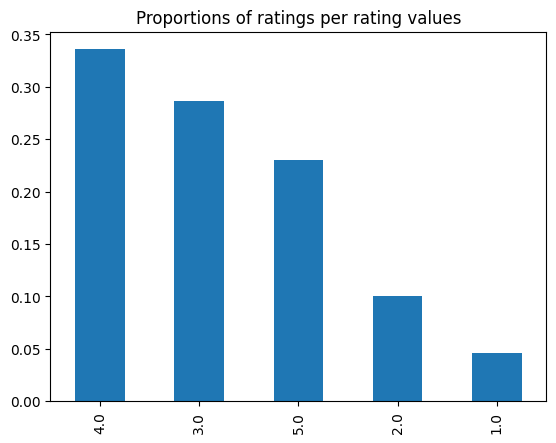

In [14]:
# Get numbers of ratings in the full dataset
df_ratings['rating'].value_counts(normalize=True).plot(kind='bar')
plt.title('Proportions of ratings per rating values')
plt.show()

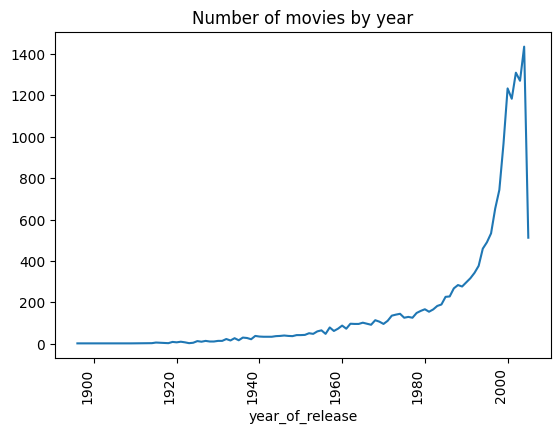

In [15]:
# Get number of movies by year of release (to observe movie growth)
df_movies.groupby('year_of_release')['movie_id'].count().plot()
plt.xticks(rotation = 90)
plt.title('Number of movies by year')
plt.show()

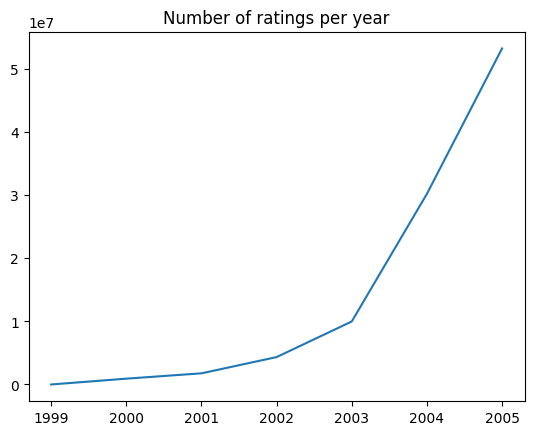

In [18]:
# Get number of ratings by year
df_ratings['year'] = df_ratings['date'].dt.year
df_ratings['year'].value_counts().plot()
plt.title("Number of ratings per year")
plt.show()

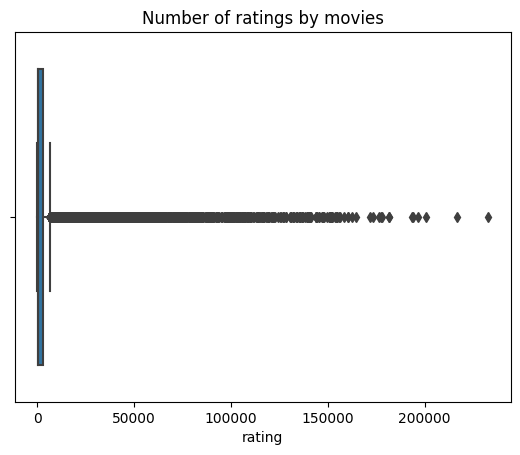

In [19]:
# Number of ratings by movies
df_movie_rating_count = df_ratings.groupby('movie_id').count()
sns.boxplot(data=df_movie_rating_count, x='rating')
plt.title("Number of ratings by movies")
plt.show()

The number of ratings per movie distribution is heavily right skewed, meaning that most of the movies has small number of ratings while there still exists a proportion of movies with relatively high number of ratings.

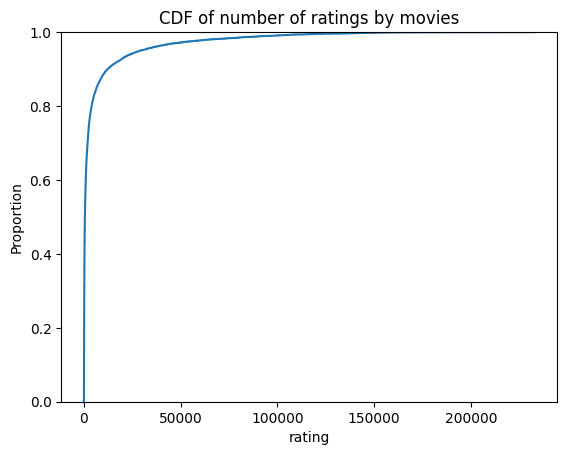

In [20]:
sns.ecdfplot(data=df_movie_rating_count, x='rating')
plt.title("CDF of number of ratings by movies")
plt.show()

In [21]:
# Get percentile of number of ratings
pd.DataFrame({
    'percentile': np.arange(5, 100, 5),
    'n_ratings': np.percentile(df_movie_rating_count['rating'], np.arange(5, 100, 5)).astype('int')
})

,percentile,n_ratings
0,5,98
1,10,117
2,15,137
3,20,161
4,25,192
5,30,228
6,35,281
7,40,349
8,45,439
9,50,561


From the observation, we may think of filtering several movies with low number of ratings to avoid movies with perfect rating but from really low number of ratings. In this notebook, I will set it to 100.

# Feature Extraction

By intuition, we can get non-personalized recommendations as follows:

- Find the movies with highest rating, and highest number of ratings
- Find the movies that gets many ratings recently

In this notebook, I will aggregated the below features for every movie:

**Normal count**: Number of ratings from the movies, each rating count as 1.

**Normal rating**: Average ratings from the movies.

**Weighted count**: Count from every rating depends on the date of creation to the current date, which follows a rule-based approach
- Ratings within 3 days (50 pts/rating)
- Ratings within 7 days (20 pts/rating)
- Ratings within 15 days (10 pts/rating)
- Ratings within 30 days (3 pts/rating)
- Ratings within 365 days (1 pts/rating)
- Otherwise (0.2 pts/rating)

**Weighted rating**: Similar to weighted count on how we defines the weight.

**Bucketed rating**
- Divide ratings into 6 groups
- Calculate the proportion of each group
- Weighted rating = average of each group (if there is no rating from that group, counted as 0
- Intuition: Reduce spammed rating in a period of time, and keep the all-time-famous movies get recommended.

In [23]:
# Displayed movies depend on day (we cannot set today since the latest movies in the dataset is in 2005)
today = '2005-01-01'
today_dt = pd.to_datetime(today)

# Count days from date of rating creation to today
df_ratings['days_from_rating'] = (today_dt - df_ratings['date']).dt.days.clip(lower=0)
df_ratings[['date', 'days_from_rating']].head()

,date,days_from_rating
1,2003-12-02,396
2,2005-06-01,0
3,2001-02-17,1414
4,2002-12-27,736
5,2002-10-11,813


In [24]:
def weighted_ratings(movie_rating_df):
    
    aggregated_data = {}
    
    def weighted_count(val):
        if val <= 3:
            return 50
        elif val <= 7:
            return 20
        elif val <= 15:
            return 10
        elif val <= 30:
            return 3
        elif val <= 365:
            return 1
        else:
            return 0.2
        
    aggregated_data['normal_count'] = len(movie_rating_df)
    aggregated_data['normal_rating'] = movie_rating_df['rating'].mean()
        
    movie_rating_df['weights'] = movie_rating_df['days_from_rating'].apply(weighted_count)
    aggregated_data['weighted_count'] = movie_rating_df['weights'].sum()
    aggregated_data['weighted_rating'] = (movie_rating_df['rating'] * movie_rating_df['weights']).sum() / movie_rating_df['weights'].sum()
    
    buckets = movie_rating_df.groupby('weights')['rating'].agg(['mean'])
    aggregated_data['bucketed_rating'] = buckets['mean'].sum() / 6    # 6 is the number of buckets
    
    return pd.Series(aggregated_data)

In [25]:
df_weighted_ratings = df_ratings[(df_ratings['days_from_rating'] != 0)].groupby('movie_id').apply(weighted_ratings)
df_weighted_ratings.head()

,normal_count,normal_rating,weighted_count,weighted_rating,bucketed_rating
movie_id,,,,,
1,199.0,3.587940,382.0,3.696335,3.092430
2,17.0,3.470588,73.0,3.945205,2.488889
3,1445.0,3.645675,1477.6,3.716703,3.646711
4,87.0,2.839080,107.4,3.163873,1.950772
5,112.0,4.366071,1310.0,4.358779,3.632480


# Implement Non-Personalized Recommendation

We will implement 2 ways to make recommendations from the extracted features:

- Take $k$ movies with highest score from every category. There may exist several movies appear in more than 1 category.
- Build a scoring system:
    - For the count, movie with highest count get 1.0 pts, 1 rank lower get 0.02 less score (if consider only top 50).
    - For the rating, movie with highest rating get 1.0 pts, score from other movies = (movie rating - 90% percentile) / (highest rating - 90% percentile)
    - Provide weights for the score to get the final aggregated score.

## Method 1: Get movies with highest score in every category

In [26]:
def make_recommendation_from_each_cat(df, k=20):
    rec = {}
    features = ['normal_count', 'normal_rating', 'weighted_count', 'weighted_rating', 'bucketed_rating']
    for feature in features:
        print("Movies with highest {}".format(feature))
        selected_movies = df.sort_values(feature, ascending=False).iloc[:k][['title', 'year_of_release', feature]]
        display(selected_movies)
        for title in selected_movies['title']:
            if title in rec:
                rec[title].append(feature)
            else:
                rec[title] = [feature]
    df_all_rec = df[df['title'].isin(rec.keys())]
    df_all_rec['reason'] = df_all_rec['title'].map(rec)
    return df_all_rec

# We don't include movies with normal_count or weighted_count less than 100
# (weighted count helps new movies still be recommended with a small number of ratings required)
df_merged = df_weighted_ratings.reset_index().merge(df_movies, on='movie_id', how='left')
df_merged = df_merged[(df_merged['normal_count'] >= 100) | (df_merged['weighted_count'] >= 100)]

df_all_rec = make_recommendation_from_each_cat(df_merged)

Movies with highest normal_count


,title,year_of_release,normal_count
13265,Independence Day,1996-01-01,108038.0
4680,Miss Congeniality,2000-01-01,107005.0
1663,Pirates of the Caribbean: The Curse of the Bla...,2003-01-01,97622.0
5536,Pretty Woman,1990-01-01,88379.0
12567,The Patriot,2000-01-01,87186.0
500,American Beauty,1999-01-01,86546.0
13659,Sweet Home Alabama,2002-01-01,83596.0
2136,Lord of the Rings: The Fellowship of the Ring,2001-01-01,82368.0
7741,The Royal Tenenbaums,2001-01-01,81673.0
10129,Lord of the Rings: The Two Towers,2002-01-01,80841.0


Movies with highest normal_rating


,title,year_of_release,normal_rating
11594,Rescue Me: Season 1,2004-01-01,5.000000
3450,Nip/Tuck: Season 2,2004-01-01,5.000000
9485,Scrubs: Season 1,2001-01-01,5.000000
6819,Anne of Green Gables,1985-01-01,4.927273
13619,Fullmetal Alchemist,2004-01-01,4.909091
6687,Queer as Folk: Season 4,2004-01-01,4.900000
3027,Lost: Season 1,2004-01-01,4.888889
7214,Deadwood: Season 1,2004-01-01,4.840000
6653,Dead Like Me: Season 2,2004-01-01,4.833333
6892,Arrested Development: Season 2,2004-01-01,4.833333


Movies with highest weighted_count


,title,year_of_release,weighted_count
10674,Spider-Man 2,2004-01-01,348610.0
5395,Collateral,2004-01-01,334823.0
4834,"""I, Robot""",2004-01-01,324462.0
2065,The Bourne Supremacy,2004-01-01,320887.0
2510,Elf,2003-01-01,301512.6
4754,Dodgeball: A True Underdog Story,2004-01-01,277934.0
3459,Shrek 2,2004-01-01,272118.0
15219,The Terminal,2004-01-01,250065.0
10839,Harry Potter and the Prisoner of Azkaban,2004-01-01,223758.0
13329,The Day After Tomorrow,2004-01-01,218814.0


Movies with highest weighted_rating


,title,year_of_release,weighted_rating
11594,Rescue Me: Season 1,2004-01-01,5.000000
3450,Nip/Tuck: Season 2,2004-01-01,5.000000
9485,Scrubs: Season 1,2001-01-01,5.000000
6687,Queer as Folk: Season 4,2004-01-01,4.966667
15107,Sealab 2021: Season 2,2002-01-01,4.931818
7646,Charmed: Season 1,1998-01-01,4.909594
6653,Dead Like Me: Season 2,2004-01-01,4.902913
3027,Lost: Season 1,2004-01-01,4.892473
6892,Arrested Development: Season 2,2004-01-01,4.882353
10254,The Sopranos: Season 5,2004-01-01,4.833333


Movies with highest bucketed_rating


,title,year_of_release,bucketed_rating
15331,The Shield: Season 2,2003-01-01,4.650340
14129,Love Hina Again: The Movie,2003-01-01,4.586591
4656,Alias: Season 2,2002-01-01,4.581962
12763,The Shawshank Redemption: Special Edition,1994-01-01,4.575514
12503,Lord of the Rings: The Return of the King,2003-01-01,4.574516
11279,Family Guy: Vol. 2: Season 3,2001-01-01,4.570210
4911,Star Wars: Episode V: The Empire Strikes Back,1980-01-01,4.567669
14259,Star Wars: Episode IV: A New Hope,1977-01-01,4.546944
13407,Band of Brothers,2001-01-01,4.541704
7240,Buffy the Vampire Slayer: Season 5,2000-01-01,4.533322


/tmp/ipykernel_34/3479274692.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_rec['reason'] = df_all_rec['title'].map(rec)


In [27]:
# List of all recommended movies from the first method
df_all_rec.sort_values(["year_of_release", "normal_rating", "normal_count"], ascending=False).set_index('movie_id')

,normal_count,normal_rating,weighted_count,weighted_rating,bucketed_rating,year_of_release,title,reason
movie_id,,,,,,,,
3928,12.0,5.000000,260.0,5.000000,2.500000,2004-01-01,Nip/Tuck: Season 2,"[normal_rating, weighted_rating]"
13205,6.0,5.000000,260.0,5.000000,1.666667,2004-01-01,Rescue Me: Season 1,"[normal_rating, weighted_rating]"
15538,22.0,4.909091,186.0,4.715054,3.152778,2004-01-01,Fullmetal Alchemist,"[normal_rating, weighted_rating]"
7605,10.0,4.900000,300.0,4.966667,1.633333,2004-01-01,Queer as Folk: Season 4,"[normal_rating, weighted_rating]"
3456,9.0,4.888889,186.0,4.892473,3.277778,2004-01-01,Lost: Season 1,"[normal_rating, weighted_rating]"
8197,25.0,4.840000,329.0,4.778116,4.000000,2004-01-01,Deadwood: Season 1,"[normal_rating, weighted_rating]"
7569,6.0,4.833333,103.0,4.902913,3.277778,2004-01-01,Dead Like Me: Season 2,"[normal_rating, weighted_rating]"
7833,6.0,4.833333,170.0,4.882353,2.444444,2004-01-01,Arrested Development: Season 2,"[normal_rating, weighted_rating]"
10598,32.0,4.812500,535.0,4.614953,3.215873,2004-01-01,Chappelle's Show: Season 2,[normal_rating]


## Method 2: Set weights for the features

In [29]:
# Make recommendation by scoring (method 2)
df_rank = df_weighted_ratings.rank(method="first", ascending=False).astype(int)
df_rank.head()

,normal_count,normal_rating,weighted_count,weighted_rating,bucketed_rating
movie_id,,,,,
1,9181,3588,8478,3361,6695
2,15018,4729,13768,1488,10191
3,4132,3094,4885,3182,2288
4,12447,11375,12741,8870,12333
5,11363,198,5178,264,2388


In [30]:
df_score = pd.DataFrame(columns=[c + "_score" for c in df_weighted_ratings.columns])
df_score['normal_count_score'] = (1 - (df_rank['normal_count'] - 1) * 0.01).clip(lower=0)
df_score['weighted_count_score'] = (1 - (df_rank['weighted_count'] - 1) * 0.01).clip(lower=0)
df_score['normal_rating_score'] = (df_weighted_ratings['normal_rating'] - df_weighted_ratings['normal_rating'].quantile(0.9)) / (df_weighted_ratings['normal_rating'].max() - df_weighted_ratings['normal_rating'].quantile(0.9))
df_score['weighted_rating_score'] = (df_weighted_ratings['weighted_rating'] - df_weighted_ratings['weighted_rating'].quantile(0.9)) / (df_weighted_ratings['weighted_rating'].max() - df_weighted_ratings['weighted_rating'].quantile(0.9))
df_score['bucketed_rating_score'] = (df_weighted_ratings['bucketed_rating'] - df_weighted_ratings['bucketed_rating'].quantile(0.9)) / (df_weighted_ratings['bucketed_rating'].max() - df_weighted_ratings['bucketed_rating'].quantile(0.9))

# Suppose we care more on trending movies
weights = [0.1, 0.1, 0.3, 0.3, 0.2]
df_score['final_score'] = (df_score.iloc[:, :5] * weights).sum(axis=1)
df_score = df_score.sort_values("final_score", ascending=False)
df_score = df_score.reset_index().merge(df_movies, on='movie_id', how='left')
df_score.iloc[:100]

,movie_id,normal_count_score,normal_rating_score,weighted_count_score,weighted_rating_score,bucketed_rating_score,final_score,year_of_release,title
0,14550,0.35,0.641595,0.80,0.606146,0.915729,0.704149,1994-01-01,The Shawshank Redemption: Special Edition
1,11521,0.91,0.518784,0.69,0.485245,0.773590,0.650170,2002-01-01,Lord of the Rings: The Two Towers
2,14240,0.45,0.594686,0.54,0.557382,0.914604,0.616604,2003-01-01,Lord of the Rings: The Return of the King
3,2452,0.93,0.472674,0.56,0.509606,0.774137,0.615977,2001-01-01,Lord of the Rings: The Fellowship of the Ring
4,3962,0.67,0.502829,0.68,0.443159,0.733300,0.600891,2003-01-01,Finding Nemo (Widescreen)
5,11283,0.88,0.380943,0.76,0.362650,0.607637,0.584417,1994-01-01,Forrest Gump
6,10042,0.00,0.584302,0.57,0.511927,0.828281,0.548665,1981-01-01,Raiders of the Lost Ark
7,1905,0.98,0.235234,0.88,0.186704,0.430829,0.527700,2003-01-01,Pirates of the Caribbean: The Curse of the Bla...
8,4306,0.68,0.429675,0.44,0.406057,0.665842,0.497953,1999-01-01,The Sixth Sense
9,12870,0.00,0.561234,0.34,0.491563,0.778816,0.461355,1993-01-01,Schindler's List


# Discussion on method 2

We can see that no movie with absolute score in some categories (1.0) appear in the list, except `bucketed_rating_score`, we will explain the reason below:

**1. Movies with high number of votes are likely to get low ratings (it gets negative when rating is less than the 90 percentile).**

In [32]:
df_score[df_score['normal_count_score'] >= 0.9]

,movie_id,normal_count_score,normal_rating_score,weighted_count_score,weighted_rating_score,bucketed_rating_score,final_score,year_of_release,title
1,11521,0.91,0.518784,0.69,0.485245,0.773590,0.650170,2002-01-01,Lord of the Rings: The Two Towers
3,2452,0.93,0.472674,0.56,0.509606,0.774137,0.615977,2001-01-01,Lord of the Rings: The Fellowship of the Ring
7,1905,0.98,0.235234,0.88,0.186704,0.430829,0.527700,2003-01-01,Pirates of the Caribbean: The Curse of the Bla...
71,6287,0.97,-0.066164,0.81,-0.088436,0.098728,0.326598,1990-01-01,Pretty Woman
80,571,0.95,0.097491,0.49,0.039191,0.222954,0.308097,1999-01-01,American Beauty
134,15124,1.00,-0.190693,0.87,-0.239257,-0.110597,0.248034,1996-01-01,Independence Day
150,14313,0.96,-0.046335,0.55,-0.103830,0.057683,0.236754,2000-01-01,The Patriot
151,4432,0.90,-0.086323,0.70,-0.180118,-0.008759,0.235581,2003-01-01,The Italian Job
764,5317,0.99,-0.425796,0.79,-0.483266,-0.395193,0.069402,2000-01-01,Miss Congeniality
797,15582,0.94,-0.365256,0.71,-0.449073,-0.356126,0.064527,2002-01-01,Sweet Home Alabama


**2. Movies with high rating are likely new rating. Therefore the scores on count is zero, and the `bucketed_rating_score` is low.**

In [31]:
df_score[df_score['normal_rating_score'] == 1].iloc[:10]

,movie_id,normal_count_score,normal_rating_score,weighted_count_score,weighted_rating_score,bucketed_rating_score,final_score,year_of_release,title
82,7669,0.0,1.0,0.0,1.0,-0.483258,0.303348,2004-01-01,Desperate Housewives: Season 1
498,3928,0.0,1.0,0.0,1.0,-1.421786,0.115643,2004-01-01,Nip/Tuck: Season 2
2097,7445,0.0,1.0,0.0,1.0,-2.360315,-0.072063,2004-01-01,Monk: Season 3
2098,10885,0.0,1.0,0.0,1.0,-2.360315,-0.072063,2004-01-01,Dead and Breakfast
2099,7184,0.0,1.0,0.0,1.0,-2.360315,-0.072063,2005-01-01,Racing Stripes
2100,11925,0.0,1.0,0.0,1.0,-2.360315,-0.072063,2003-01-01,The Wire: Season 2
2101,16059,0.0,1.0,0.0,1.0,-2.360315,-0.072063,2003-01-01,Ween: Live in Chicago
2102,1073,0.0,1.0,0.0,1.0,-2.360315,-0.072063,2005-01-01,Coach Carter
2103,16047,0.0,1.0,0.0,1.0,-2.360315,-0.072063,2005-01-01,Because of Winn-Dixie
2104,10778,0.0,1.0,0.0,1.0,-2.360315,-0.072063,2001-01-01,Scrubs: Season 1


# Find overlap recommendations between 2 methods

In [33]:
movies_method_1 = set(df_all_rec['title'])
movies_method_2 = set(df_score.iloc[:100]['title'])

overlapping_movies = movies_method_1.intersection(movies_method_2)
overlapping_movies

{'24: Season 2',
 'Alias: Season 1',
 'Alias: Season 2',
 'American Beauty',
 'Anne of Green Gables',
 'Babylon 5: Season 4',
 'Band of Brothers',
 'Buffy the Vampire Slayer: Season 2',
 'Buffy the Vampire Slayer: Season 5',
 'CSI: Season 2',
 'Charmed: Season 1',
 'Deadwood: Season 1',
 'Family Guy: Vol. 2: Season 3',
 'Farscape: Season 4',
 'Forrest Gump',
 'Happy Gilmore',
 'Harry Potter and the Prisoner of Azkaban',
 'Inu-Yasha: The Movie 2: The Castle Beyond the Looking Glass',
 'Lord of the Rings: The Fellowship of the Ring',
 'Lord of the Rings: The Return of the King',
 'Lord of the Rings: The Two Towers',
 'Love Hina Again: The Movie',
 'Mobile Suit Gundam SEED',
 "Ocean's Eleven",
 'Pirates of the Caribbean: The Curse of the Black Pearl',
 'Pretty Woman',
 'Sex and the City: Season 6: Part 2',
 'Shrek 2',
 'Star Wars: Episode IV: A New Hope',
 'Star Wars: Episode V: The Empire Strikes Back',
 'The Godfather',
 'The Golden Girls: Season 1',
 'The Green Mile',
 'The Notebook',


In [34]:
print("There exists {} movies that appears in both method".format(len(overlapping_movies)))

There exists 40 movies that appears in both method


# Conclusion

In this notebook, we have quickly process data, extract aggregated features, and make non-personalized recommendations on this data with 2 methods: best in any feature, or ranking by weighted score.

In fact, a movie may have more information, such as category so that we can get recommendation when clicking specifically in a category. But it is just another step.

## Future works

I will perform analysis on the change of weighted score in method 2 over time to clearly see how the score changes and whether it can be manipulated. Also, other types of recommendation, such as content-based, collaborative filter, or hybrid approaches will be explored.

Hope that this notebook is useful for learning together, let me know if you have any inquiries or suggestions to improve this notebook.